In [1]:
import torch
import torch.nn as nn


In [2]:
#W8A16 Linear Layer

def linear_quantize(tensor, dtype=torch.int8):
    r_min = tensor.min().item()
    r_max = tensor.max().item()
    
    q_min = torch.iinfo(dtype).min
    q_max = torch.iinfo(dtype).max
    
    scale = (r_max - r_min) / (q_max - q_min)
    zero_point = torch.round(torch.tensor(q_min - (r_min / scale))).to(torch.int8).item()

    zero_point = torch.clamp_(torch.tensor(zero_point), min=q_min, max=q_max)
    
    quantized_tensor = torch.round(tensor / scale + zero_point)
    quantized_tensor = torch.clamp_(quantized_tensor, min=q_min, max=q_max).to(torch.int8)
    return scale, zero_point.item(), quantized_tensor

def channel_linear_quantize(tensor, dim=0, dtype=torch.int8):
    scales = torch.zeros(tensor.size(dim))
    zero_pts = torch.zeros(tensor.size(dim), dtype=torch.int8)


    quantized_tensor = torch.zeros_like(tensor, dtype=dtype)

    for i in range(tensor.size(dim)):
        scales[i], zero_pts[i], quant = linear_quantize(tensor.select(dim, i), dtype=dtype)

        if dim == 1:
            quantized_tensor[:, i] = quant
        else:
            quantized_tensor[i, :] = quant
            
    if (dim == 0):
        scales = scales.view(scales.shape[dim], -1)
        zero_pts = zero_pts.view(zero_pts.shape[dim], -1)
    elif dim == 1:
        
        scales = scales.view(-1, scales.shape[0])
        zero_pts = zero_pts.view(-1, zero_pts.shape[0])
        
    # quantized_tensor = torch.clamp_(torch.round(tensor / scales + zero_pts), 
    #                                   min=torch.iinfo(dtype).min, 
    #                                   max=torch.iinfo(dtype).max).to(torch.int)
    return scales, zero_pts, quantized_tensor

In [3]:
torch.randn(3,1)

tensor([[ 0.4481],
        [-0.3558],
        [-0.4173]])

In [4]:

class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features=4, out_features=4, dtype=torch.float32, bias=False):
        super(W8A16LinearLayer, self).__init__()
        self.register_buffer('int8_weights', torch.randint(torch.iinfo(torch.int8).min, torch.iinfo(torch.int8).max, (in_features, out_features), dtype=torch.int8))
        self.register_buffer('scales', torch.randn(out_features, 1, dtype=torch.float32))
        self.register_buffer('zero_point', torch.randint(torch.iinfo(torch.int8).min, torch.iinfo(torch.int8).max, (out_features, 1), dtype=torch.int8))
        self.dtype = dtype
        if bias:
            self.register_buffer('bias', torch.empty(out_features, dtype=dtype))
        else:
            self.bias = None


    def quantize(self, x):
        x = x.to(torch.float32)
        scales, zero_pts, quant_weights = channel_linear_quantize(x, dim=0)
        #    Use .copy_() for an in-place update.
        # print(scales.shape)
        # print(zero_pts.shape)
        # print(self.scales.shape)
        # print(self.zero_point.shape)
        self.int8_weights.copy_(quant_weights)
        self.scales.copy_(scales) 
        self.zero_point.copy_(zero_pts)
        return scales, zero_pts, quant_weights
    
    def linear_dequantize(self, scales, zero_pts, quant):
        return scales * (quant.float() - zero_pts)
    
    def forward(self, x, scales, zero_point, dtype=torch.bfloat16):
        dequant = self.linear_dequantize(scales, zero_point, self.int8_weights)
        out = torch.matmul(x.to(dtype), dequant.to(self.dtype)) + (self.bias if self.bias is not None else 0.0)
        return out

In [5]:
def linear_dequantize(scale, zero_point, quantized_tensor):
    return scale * (quantized_tensor.float() - zero_point)


In [6]:
# Corrected test code
quantized_ly = W8A16LinearLayer()

# Store original weights before quantization
original_weights = quantized_ly.int8_weights.clone()
print(original_weights.dtype)

# Quantize the weights
scales, zero_pts, quant = quantized_ly.quantize(original_weights)

# Dequantize to check reconstruction quality
dequantized_weights = quantized_ly.linear_dequantize(scales, zero_pts, quant)

# Calculate MSE between original and reconstructed weights
weight_mse = (dequantized_weights - original_weights).pow(2).mean()
print(f"Weight reconstruction MSE: {weight_mse}")

# For forward pass comparison
test_input = torch.randn(1, 16, dtype=torch.bfloat16)  # Batch size 1


torch.int8
Weight reconstruction MSE: 0.025876469910144806


In [12]:
original_weights

tensor([[-0.4041,  0.1341,  1.0847,  0.8148],
        [ 2.0757, -1.3028,  0.8009, -0.6891],
        [ 1.1807, -0.4752,  0.8403,  0.4074],
        [ 0.2268,  0.4341, -1.1102, -0.0937]])

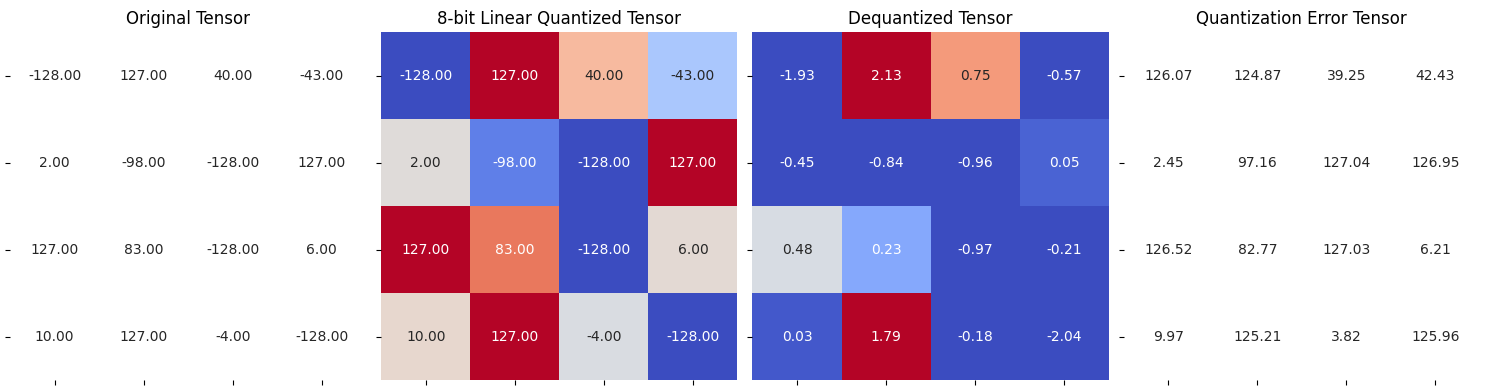

In [7]:
from helper import plot_quantization_errors

plot_quantization_errors(original_weights, quant, dequantized_weights)

In [95]:
print("Original Tensor:\n", test_tensor)
print("Scales:\n", scales.shape)
print("Zero Points:\n", zero_pts.shape)
print("Quantized Tensor:\n", quant)
print("dequantized_tensor:\n", dequantized_weights)
    

Original Tensor:
 tensor([[ 4.1602e-01, -4.3555e-01, -1.0625e+00,  6.9141e-01, -7.9688e-01,
          1.3594e+00, -9.6875e-01, -3.3203e-01,  4.8242e-01, -7.5391e-01,
         -7.3828e-01,  1.1562e+00, -1.6309e-01,  7.2266e-01, -1.2061e-01,
         -1.3281e+00],
        [ 1.8516e+00,  2.4121e-01,  2.0508e-01,  1.1875e+00, -1.1172e+00,
         -3.4375e-01, -9.1016e-01, -5.1562e-01, -6.1523e-02,  1.2188e+00,
         -8.9453e-01,  9.7266e-01,  1.0781e+00,  7.2266e-01, -7.0312e-02,
          2.7148e-01],
        [ 3.5352e-01, -9.7656e-01,  2.8320e-01, -2.5977e-01,  1.8359e-01,
         -5.4297e-01,  2.0020e-01,  1.8125e+00, -8.8281e-01,  2.9531e+00,
          2.5586e-01,  1.5000e+00, -5.0000e-01,  9.4727e-02,  1.5859e+00,
         -8.5156e-01],
        [-5.5469e-01,  1.7266e+00, -9.7266e-01,  1.2031e+00,  8.3594e-01,
          1.4453e+00,  2.3730e-01,  1.5234e+00,  9.6094e-01, -5.7373e-02,
         -1.0547e+00,  1.3281e+00,  1.6406e+00, -9.3750e-02,  4.1797e-01,
         -3.4180e-01],
  

In [96]:
(dequantized_weights - initial_weights).square().mean()  # should be small, e.g., < 1e-2

tensor(11753.8945)